In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from datetime import datetime
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import time


class BantAI_TravelAware:
    def __init__(self):
        self.model = None
        # initialize geolocator once
        self.geolocator = Nominatim(user_agent="bantai_ai")
        # cache to avoid repeated API calls
        self.geo_cache = {}

    def get_coordinates(self, city, country):
        """Convert city + country into latitude/longitude (with caching)"""
        if pd.isna(city) or pd.isna(country):
            return None

        key = f"{city},{country}"
        if key in self.geo_cache:
            return self.geo_cache[key]

        try:
            location = self.geolocator.geocode(key, timeout=10)
            if location:
                coords = (location.latitude, location.longitude)
                self.geo_cache[key] = coords
                time.sleep(1)  # avoid rate limit
                return coords
        except Exception as e:
            print(f"Geocoding error for {key}: {e}")

        self.geo_cache[key] = None
        return None

    def compute_distance(self, last_city, last_country, curr_city, curr_country):
        coords1 = self.get_coordinates(last_city, last_country)
        coords2 = self.get_coordinates(curr_city, curr_country)
        if coords1 and coords2:
            return geodesic(coords1, coords2).kilometers
        return 0  # fallback if geocoding fails

    def get_zone_risk(self, city):
        """Assign a zone risk score based on location (extendable)"""
        risk_zones = {"Dubai": 3, "Singapore": 2, "Manila": 1}
        return risk_zones.get(city, 1)

    def compute_features(self, last_login, current_login):
        distance_km = self.compute_distance(
            last_login["city"], last_login["country"],
            current_login["city"], current_login["country"]
        )

        time_gap = (current_login["time"] - last_login["time"]).total_seconds() / 3600.0
        travel_speed = distance_km / time_gap if time_gap > 0 else 0
        zone_risk_score = self.get_zone_risk(current_login["city"])

        return {
            "distance_km": distance_km,
            "time_gap_hours": time_gap,
            "travel_speed": travel_speed,
            "zone_risk_score": zone_risk_score,
        }

    def prepare_training_data(self, df):
        """ Convert login history DataFrame into feature matrix and labels """
        X, y = [], []
        for i in range(1, len(df)):
            last_login = df.iloc[i-1].to_dict()
            current_login = df.iloc[i].to_dict()
            features = self.compute_features(last_login, current_login)
            X.append(list(features.values()))
            y.append(current_login["label"])  # 0 = legit, 1 = suspicious
        return pd.DataFrame(X, columns=["distance_km","time_gap_hours","travel_speed","zone_risk_score"]), y

    def train_model_from_csv(self, csv_path):
        df = pd.read_csv(csv_path)
        # df = pd.read_csv(csv_path, nrows=100000)  # only first 100k rows
        df = df.sample(n=100, random_state=42)  # random subset

        # Map dataset columns into expected names
        df = df.rename(columns={
            "Login Timestamp": "time",
            "Country": "country",
            "City": "city",
            "Is Attack IP": "label"   # <-- OR use "Is Account Takeover"
        })

        # Ensure time is datetime
        df["time"] = pd.to_datetime(df["time"], errors="coerce")
        df = df.dropna(subset=["time", "city", "country", "label"])
        df = df.sort_values("time")

        X, y = self.prepare_training_data(df)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        print("Model Performance:")
        print(classification_report(y_test, y_pred))

        self.model = clf



In [7]:
bantay = BantAI_TravelAware()
bantay.train_model_from_csv(r"C:\Users\Brando\Desktop\School\Project\BantAI_Datawave\rba-dataset.csv")



Model Performance:
              precision    recall  f1-score   support

       False       0.90      1.00      0.95        18
        True       0.00      0.00      0.00         2

    accuracy                           0.90        20
   macro avg       0.45      0.50      0.47        20
weighted avg       0.81      0.90      0.85        20



c:\Users\Brando\miniconda3\envs\BantAI\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Brando\miniconda3\envs\BantAI\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Brando\miniconda3\envs\BantAI\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

In [37]:
import os
import json
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from datetime import datetime
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Optional: SMOTE for balancing
try:
    from imblearn.over_sampling import SMOTE
    IMB_AVAILABLE = True
except ImportError:
    print("⚠️ imbalanced-learn not installed. Run: pip install imbalanced-learn")
    IMB_AVAILABLE = False


class BantAI_TravelAware:
    def __init__(self, cache_file="geocache.json"):
        self.model = None
        self.geolocator = Nominatim(user_agent="bantai_ai")
        self.cache_file = cache_file
        self.geo_cache = self.load_cache()

    # ------------------------
    # Cache handling
    # ------------------------
    def load_cache(self):
        if os.path.exists(self.cache_file):
            with open(self.cache_file, "r") as f:
                return json.load(f)
        return {}

    def save_cache(self):
        with open(self.cache_file, "w") as f:
            json.dump(self.geo_cache, f)

    # ------------------------
    # Geocoding with cache + rate limit
    # ------------------------
    def get_coordinates(self, city, country, delay=1.0):
        if pd.isna(city) or pd.isna(country):
            return None

        key = f"{city},{country}"
        if key in self.geo_cache:
            return tuple(self.geo_cache[key]) if self.geo_cache[key] else None

        try:
            location = self.geolocator.geocode(key, timeout=10)
            time.sleep(delay)  # ⏱ Respect Nominatim 1 req/sec
            if location:
                coords = (location.latitude, location.longitude)
                self.geo_cache[key] = coords
                self.save_cache()
                return coords
        except Exception as e:
            print(f"⚠️ Geocoding error for {key}: {e}")

        self.geo_cache[key] = None
        self.save_cache()
        return None

    def precompute_all_coords(self, df):
        """Pre-compute coords for all unique city-country pairs"""
        unique_locations = df[["city", "country"]].drop_duplicates()

        print(f"🔍 Precomputing coordinates for {len(unique_locations)} unique city-country pairs...")
        for _, row in tqdm(unique_locations.iterrows(), total=len(unique_locations)):
            self.get_coordinates(row["city"], row["country"])

        print("✅ All coordinates cached!")

    # ------------------------
    # Feature Engineering
    # ------------------------
    def compute_distance(self, last_city, last_country, curr_city, curr_country):
        coords1 = self.get_coordinates(last_city, last_country)
        coords2 = self.get_coordinates(curr_city, curr_country)
        if coords1 and coords2:
            return geodesic(coords1, coords2).kilometers
        return 0

    def get_zone_risk(self, city):
        risk_zones = {"Dubai": 3, "Singapore": 2, "Manila": 1}
        return risk_zones.get(city, 1)

    def compute_features(self, last_login, current_login):
        distance_km = self.compute_distance(
            last_login["city"], last_login["country"],
            current_login["city"], current_login["country"]
        )

        time_gap = (current_login["time"] - last_login["time"]).total_seconds() / 3600.0
        travel_speed = distance_km / time_gap if time_gap > 0 else 0
        zone_risk_score = self.get_zone_risk(current_login["city"])

        return {
            "distance_km": distance_km,
            "time_gap_hours": time_gap,
            "travel_speed": travel_speed,
            "zone_risk_score": zone_risk_score,
        }

    def prepare_training_data(self, df):
        X, y = [], []
        for i in range(1, len(df)):
            last_login = df.iloc[i-1].to_dict()
            current_login = df.iloc[i].to_dict()
            features = self.compute_features(last_login, current_login)
            X.append(list(features.values()))
            y.append(current_login["label"])
        return pd.DataFrame(X, columns=["distance_km","time_gap_hours","travel_speed","zone_risk_score"]), y

    # ------------------------
    # Training
    # ------------------------
    def train_model_from_csv(self, csv_path, nrows=1000, use_smote=True):
        df = pd.read_csv(csv_path, nrows=nrows)

        # Replace "-" with None in Region and City
        df["Region"] = df["Region"].replace("-", None)
        df["City"] = df["City"].replace("-", None)

        print(f"📂 Training on {len(df)} records after cleaning...")

        # Map dataset columns
        df = df.rename(columns={
            "Login Timestamp": "time",
            "Country": "country",
            "City": "city",
            "Is Attack IP": "label"   # or "Is Account Takeover"
        })

        df["time"] = pd.to_datetime(df["time"], errors="coerce")
        df = df.dropna(subset=["time", "city", "country", "label"])
        df = df.sort_values("time")

        # Precompute coords before training
        self.precompute_all_coords(df)

        # Build features
        X, y = self.prepare_training_data(df)

        # Show class distribution
        print("⚖️ Class distribution before training:")
        print(pd.Series(y).value_counts())

        # Split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Optionally balance with SMOTE
        if use_smote and IMB_AVAILABLE:
            print("✨ Applying SMOTE oversampling...")
            smote = SMOTE(random_state=42)
            X_train, y_train = smote.fit_resample(X_train, y_train)

        # Train
        clf = RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            class_weight="balanced"
        )
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        print("📊 Model Performance:")
        print(classification_report(y_test, y_pred))

        self.model = clf

        print("📊 Model Performance:")
        print(classification_report(y_test, y_pred))

        # 🔍 Confusion Matrix
        cm = confusion_matrix(y_test, y_pred, labels=[False, True])
        plt.figure(figsize=(6,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Legit (Pred)", "Attack (Pred)"],
                    yticklabels=["Legit (True)", "Attack (True)"])
        plt.title("Confusion Matrix")
        plt.ylabel("Actual")
        plt.xlabel("Predicted")
        plt.show()

        print("📊 Model Performance:")
        print(classification_report(y_test, y_pred))

        # ------------------------
        # Confusion Matrix
        # ------------------------
        cm = confusion_matrix(y_test, y_pred, labels=[False, True])
        plt.figure(figsize=(6,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Legit (Pred)", "Attack (Pred)"],
                    yticklabels=["Legit (True)", "Attack (True)"])
        plt.title("Confusion Matrix")
        plt.ylabel("Actual")
        plt.xlabel("Predicted")
        plt.show()

        # ------------------------
        # ROC Curve + AUC
        # ------------------------
        if hasattr(self.model, "predict_proba"):
            y_proba = self.model.predict_proba(X_test)[:,1]
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)

            plt.figure(figsize=(6,4))
            plt.plot(fpr, tpr, color="darkorange", lw=2,
                     label=f"ROC curve (area = {roc_auc:.2f})")
            plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("Receiver Operating Characteristic (ROC)")
            plt.legend(loc="lower right")
            plt.show()




# conda install -c conda-forge tqdm
# pip install imbalanced-learn


In [34]:
bantay = BantAI_TravelAware()
bantay.train_model_from_csv(r"C:\Users\Brando\Desktop\School\Project\BantAI_Datawave\rba-dataset.csv", nrows=20000)



📂 Training on 20000 records after cleaning...
🔍 Precomputing coordinates for 1260 unique city-country pairs...


100%|██████████| 1260/1260 [09:48<00:00,  2.14it/s]


✅ All coordinates cached!
⚖️ Class distribution before training:
False    10889
True       466
Name: count, dtype: int64
✨ Applying SMOTE oversampling...
📊 Model Performance:
              precision    recall  f1-score   support

       False       0.96      0.79      0.87      2178
        True       0.06      0.30      0.10        93

    accuracy                           0.77      2271
   macro avg       0.51      0.54      0.48      2271
weighted avg       0.93      0.77      0.83      2271



In [36]:
    # ------------------------
    # Prediction
    # ------------------------
def predict_login(self, last_login, current_login):
    if not self.model:
        raise Exception("Model not trained yet.")

    features = self.compute_features(last_login, current_login)
    X_new = pd.DataFrame([features])
    return self.model.predict(X_new)[0]


In [6]:
#
import os
import json
import time
import math
import joblib
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from sklearn.preprocessing import StandardScaler

# Optional libraries
try:
    from imblearn.over_sampling import SMOTE
    IMB_AVAILABLE = True
except Exception:
    IMB_AVAILABLE = False

# tqdm fallback
try:
    from tqdm import tqdm
except Exception:
    tqdm = lambda iterable, **kwargs: iterable

# plotting libs (optional display)
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")


class BantAI_TravelAware:
    def __init__(self,
                 cache_file="geocache.json",
                 geocode_delay=1.0,
                 ml_model_path="bantai_model.pkl",
                 ml_model_feature_columns=None):
        """
        cache_file: path to JSON cache for geocoding
        geocode_delay: seconds between geocode requests (respect Nominatim policies)
        ml_model_path: where to save the trained ML model
        ml_model_feature_columns: optional list of what ML features to expect (auto-filled)
        """
        self.model = None
        self.scaler = None
        self.geolocator = Nominatim(user_agent="bantai_ai")
        self.cache_file = cache_file
        self.geo_cache = self._load_cache()
        self.geocode_delay = geocode_delay
        self.ml_model_path = ml_model_path
        self.ml_feature_columns = ml_model_feature_columns

    # ------------------------
    # Cache handling
    # ------------------------
    def _load_cache(self):
        if os.path.exists(self.cache_file):
            try:
                with open(self.cache_file, "r", encoding="utf-8") as f:
                    return json.load(f)
            except Exception:
                return {}
        return {}

    def _save_cache(self):
        with open(self.cache_file, "w", encoding="utf-8") as f:
            json.dump(self.geo_cache, f)

    # ------------------------
    # Geocoding with cache + rate limit
    # ------------------------
    def get_coordinates(self, city, country):
        """Return (lat, lon) or None. Skips invalid inputs."""
        if pd.isna(city) or pd.isna(country):
            return None
        if str(city).strip() == "-" or str(country).strip() == "-":
            return None

        key = f"{city.strip()},{country.strip()}"
        if key in self.geo_cache:
            val = self.geo_cache[key]
            return tuple(val) if val is not None else None

        # Not in cache -> geocode
        try:
            location = self.geolocator.geocode(key, timeout=10)
            time.sleep(self.geocode_delay)  # rate limit
            if location:
                coords = (location.latitude, location.longitude)
                self.geo_cache[key] = coords
                self._save_cache()
                return coords
        except Exception as e:
            # store None to avoid repeated attempts
            print(f"⚠️ Geocoding error for {key}: {e}")
        self.geo_cache[key] = None
        self._save_cache()
        return None

    def precompute_all_coords(self, df):
        """Precompute coordinates for all unique (city,country) pairs in df."""
        if not {"city", "country"}.issubset(set(df.columns)):
            return
        unique_locations = df[["city", "country"]].drop_duplicates()
        print(f"🔍 Precomputing coordinates for {len(unique_locations)} unique city-country pairs...")
        for _, row in tqdm(unique_locations.iterrows(), total=len(unique_locations)):
            self.get_coordinates(row["city"], row["country"])
        print("✅ All coordinates cached!")

    # ------------------------
    # Travel & distance helpers
    # ------------------------
    def compute_distance_km(self, city1, country1, city2, country2):
        c1 = self.get_coordinates(city1, country1)
        c2 = self.get_coordinates(city2, country2)
        if c1 and c2:
            try:
                return geodesic(c1, c2).kilometers
            except Exception:
                return 0.0
        return 0.0

    def travel_plausibility(self, last_time, last_city, last_country, curr_time, curr_city, curr_country):
        """
        Returns dict with distance_km, time_gap_hours, travel_speed_kmh, plausible(bool), travel_risk (0-1)
        """
        distance_km = self.compute_distance_km(last_city, last_country, curr_city, curr_country)
        time_gap_hours = (curr_time - last_time).total_seconds() / 3600.0 if curr_time and last_time else np.inf

        max_speed = 900.0  # km/h for commercial aircraft
        min_travel_time = distance_km / max_speed if max_speed > 0 else np.inf
        buffer = 4.0  # hours for airport/layovers
        required = min_travel_time + buffer

        if distance_km == 0:
            plausible = True
            travel_risk = 0.0
        elif time_gap_hours >= required:
            plausible = True
            travel_risk = 0.0
        else:
            plausible = False
            # risk modifier proportional to how impossible
            ratio = (required - time_gap_hours) / (required + 1e-6)
            travel_risk = min(1.0, 0.6 + 0.4 * ratio)  # base high risk for impossible travel

        return {
            "distance_km": distance_km,
            "time_gap_hours": time_gap_hours,
            "travel_speed_kmh": (distance_km / time_gap_hours) if time_gap_hours > 0 else 0.0,
            "plausible": plausible,
            "travel_risk": travel_risk,
            "required_hours": required
        }

    # ------------------------
    # Behavioral consistency
    # ------------------------
    def behavioral_consistency_score(self, user_history_df, current_row):
        """
        user_history_df: DataFrame of previous logins for the same user (sorted by time)
        current_row: a dict/Series for current login
        Returns score in [0,1] where 1 = fully consistent.
        """
        # Default score
        score = 1.0
        factors = []

        # Device consistency
        prev_devices = user_history_df["Device Type"].dropna().unique().tolist() if "Device Type" in user_history_df else []
        curr_device = current_row.get("Device Type", None)
        if curr_device in prev_devices:
            factors.append("Known device")
        else:
            score -= 0.25
            factors.append("New device")

        # Time-of-day consistency
        if "Login Timestamp" in user_history_df:
            hist_hours = pd.to_datetime(user_history_df["Login Timestamp"]).dt.hour.dropna().tolist()
            if len(hist_hours) > 0:
                curr_hour = pd.to_datetime(current_row["Login Timestamp"]).hour
                avg = np.mean(hist_hours)
                if abs(curr_hour - avg) <= 3:
                    factors.append("Time consistent")
                else:
                    score -= 0.15
                    factors.append("Unusual hour")
        else:
            factors.append("No time history")

        # Location familiarity
        prev_countries = user_history_df["Country"].dropna().unique().tolist() if "Country" in user_history_df else []
        if current_row.get("Country") in prev_countries:
            factors.append("Known country")
            score += 0.05
        else:
            factors.append("New country")

        # Device/browser fingerprint approximation (based on UA string change)
        prev_ua = user_history_df["User Agent String"].dropna().astype(str).unique().tolist() if "User Agent String" in user_history_df else []
        curr_ua = str(current_row.get("User Agent String", ""))
        if any(curr_ua == ua for ua in prev_ua):
            factors.append("Same UA")
        else:
            score -= 0.1
            factors.append("UA changed")

        # Clamp
        score = max(0.0, min(1.0, score))
        return {"consistency_score": score, "factors": factors}

    # ------------------------
    # Technical indicator scoring
    # ------------------------
    def technical_score(self, row):
        """
        Build technical risk score in [0,1] based on available indicators.
        Use Round-Trip Time (ms) as high_latency, Is Attack IP, Login Successful.
        """
        score = 0.0
        factors = []

        # Attack IP
        attack_ip = False
        if "Is Attack IP" in row:
            val = row["Is Attack IP"]
            # Support both boolean and strings
            if isinstance(val, str):
                attack_ip = val.strip().upper() in ["TRUE", "1", "YES"]
            else:
                attack_ip = bool(val)
        if attack_ip:
            score += 0.6
            factors.append("Known attack IP")

        # High latency
        if "Round-Trip Time [ms]" in row:
            try:
                rtt = float(row["Round-Trip Time [ms]"])
                if rtt > 500:  # threshold for suspiciously high latency
                    score += 0.25
                    factors.append("High RTT")
            except Exception:
                pass

        # Failed login
        if "Login Successful" in row:
            ok = row["Login Successful"]
            # handle string forms
            if isinstance(ok, str):
                success = ok.strip().upper() in ["TRUE", "1", "YES"]
            else:
                success = bool(ok)
            if not success:
                score += 0.35
                factors.append("Failed login")

        # normalize to [0,1]
        score = min(1.0, score)
        return {"technical_score": score, "factors": factors}

    # ------------------------
    # Feature engineering for ML
    # ------------------------
    def build_ml_features_for_df(self, df):
        """
        Build ML feature matrix from chronological df.
        Expects df to contain: time (parsed), Country, City, Device Type, Round-Trip Time [ms], Is Attack IP, Login Successful, User Agent String, ASN
        Returns X (DataFrame), y (Series)
        Each sample corresponds to a login event with features computed w.r.t. previous event of same user.
        """
        # Ensure necessary columns exist
        # We'll create features per consecutive pair; below we assume df sorted by time globally (or per user)
        rows = []
        labels = []
        # We will group by user to create meaningful last_login per user
        groupby_user = "User ID" if "User ID" in df.columns else None

        if groupby_user:
            for user, group in df.groupby(groupby_user):
                group = group.sort_values("time")
                if len(group) < 2:
                    continue
                prev = None
                for idx, row in group.iterrows():
                    if prev is None:
                        prev = row
                        continue
                    curr = row
                    # Features: travel-based
                    dist = self.compute_distance_km(prev.get("City"), prev.get("Country"), curr.get("City"), curr.get("Country"))
                    time_gap = (pd.to_datetime(curr["time"]) - pd.to_datetime(prev["time"])).total_seconds() / 3600.0
                    travel_speed = dist / time_gap if time_gap > 0 else 0.0
                    impossible_flag = 1 if (not self.travel_plausibility(pd.to_datetime(prev["time"]), prev.get("City"), prev.get("Country"), pd.to_datetime(curr["time"]), curr.get("City"), curr.get("Country"))["plausible"]) else 0

                    # Temporal features
                    hour = pd.to_datetime(curr["time"]).hour
                    night_access = 1 if (hour >= 22 or hour <= 5) else 0
                    business_hours = 1 if (8 <= hour <= 17) else 0
                    hour_norm = hour / 23.0
                    day_norm = pd.to_datetime(curr["time"]).weekday() / 6.0

                    # Device features
                    mobile_device = 1 if isinstance(curr.get("Device Type", ""), str) and "mobile" in curr.get("Device Type", "").lower() else 0
                    device_change = 1 if prev.get("Device Type") != curr.get("Device Type") else 0

                    # Technical features
                    attack_ip = 1 if str(curr.get("Is Attack IP", False)).strip().upper() in ["TRUE", "1", "YES"] else 0
                    try:
                        rtt = float(curr.get(["Round-Trip Time [ms]"]) if curr.get("Round-Trip Time [ms]") is not None else 0.0)
                    except Exception:
                        rtt = 0.0
                    high_latency = 1 if rtt > 500 else 0
                    failed_login = 0
                    if "Login Successful" in curr:
                        v = curr["Login Successful"]
                        if isinstance(v, str):
                            failed_login = 0 if v.strip().upper() in ["TRUE", "1", "YES"] else 1
                        else:
                            failed_login = 0 if bool(v) else 1

                    # ASN change (proxy suspicion)
                    asn_change = 1 if prev.get("ASN") != curr.get("ASN") else 0

                    # Foreign access
                    foreign_access = 0 if str(curr.get("Country", "")).strip().upper() in ["PH", "PHL", "PHILIPPINES"] else 1

                    # Simple metro_manila flag
                    metro_manila = 1 if str(curr.get("City", "")).strip().lower() in ["manila", "quezon city", "makati", "taguig", "pasig"] else 0

                    features = {
                        "distance_km": dist,
                        "time_gap_hours": time_gap,
                        "travel_speed_kmh": travel_speed,
                        "impossible_travel": impossible_flag,
                        "night_access": night_access,
                        "business_hours": business_hours,
                        "hour_norm": hour_norm,
                        "day_norm": day_norm,
                        "mobile_device": mobile_device,
                        "device_change": device_change,
                        "attack_ip": attack_ip,
                        "high_latency": high_latency,
                        "failed_login": failed_login,
                        "asn_change": asn_change,
                        "foreign_access": foreign_access,
                        "metro_manila": metro_manila,
                        "rtt_ms": rtt
                    }

                    rows.append(features)
                    # label: use specified label column 'label' if present in df (i.e., mapped before calling)
                    labels.append(1 if str(curr.get("label", False)).strip().upper() in ["TRUE", "1", "YES"] else 0)
                    prev = curr
        else:
            # If no user id, we fallback to using consecutive global rows (less ideal)
            df = df.sort_values("time")
            prev = None
            for idx, curr in df.iterrows():
                if prev is None:
                    prev = curr
                    continue
                dist = self.compute_distance_km(prev.get("City"), prev.get("Country"), curr.get("City"), curr.get("Country"))
                time_gap = (pd.to_datetime(curr["time"]) - pd.to_datetime(prev["time"])).total_seconds() / 3600.0
                travel_speed = dist / time_gap if time_gap > 0 else 0.0
                impossible_flag = 1 if (not self.travel_plausibility(pd.to_datetime(prev["time"]), prev.get("City"), prev.get("Country"), pd.to_datetime(curr["time"]), curr.get("City"), curr.get("Country"))["plausible"]) else 0
                hour = pd.to_datetime(curr["time"]).hour
                night_access = 1 if (hour >= 22 or hour <= 5) else 0
                business_hours = 1 if (8 <= hour <= 17) else 0
                hour_norm = hour / 23.0
                day_norm = pd.to_datetime(curr["time"]).weekday() / 6.0
                mobile_device = 1 if isinstance(curr.get("Device Type", ""), str) and "mobile" in curr.get("Device Type", "").lower() else 0
                device_change = 1 if prev.get("Device Type") != curr.get("Device Type") else 0
                attack_ip = 1 if str(curr.get("Is Attack IP", False)).strip().upper() in ["TRUE", "1", "YES"] else 0
                try:
                        rtt_val = curr.get("Round-Trip Time [ms]", 0.0)
                        rtt = float(rtt_val) if rtt_val is not None else 0.0
                except Exception:
                    rtt = 0.0
                high_latency = 1 if rtt > 500 else 0
                failed_login = 0
                if "Login Successful" in curr:
                    v = curr["Login Successful"]
                    if isinstance(v, str):
                        failed_login = 0 if v.strip().upper() in ["TRUE", "1", "YES"] else 1
                    else:
                        failed_login = 0 if bool(v) else 1
                asn_change = 1 if prev.get("ASN") != curr.get("ASN") else 0
                foreign_access = 0 if str(curr.get("Country", "")).strip().upper() in ["PH", "PHL", "PHILIPPINES"] else 1
                metro_manila = 1 if str(curr.get("City", "")).strip().lower() in ["manila", "quezon city", "makati", "taguig", "pasig"] else 0

                features = {
                    "distance_km": dist,
                    "time_gap_hours": time_gap,
                    "travel_speed_kmh": travel_speed,
                    "impossible_travel": impossible_flag,
                    "night_access": night_access,
                    "business_hours": business_hours,
                    "hour_norm": hour_norm,
                    "day_norm": day_norm,
                    "mobile_device": mobile_device,
                    "device_change": device_change,
                    "attack_ip": attack_ip,
                    "high_latency": high_latency,
                    "failed_login": failed_login,
                    "asn_change": asn_change,
                    "foreign_access": foreign_access,
                    "metro_manila": metro_manila,
                    "rtt_ms": rtt
                }
                rows.append(features)
                labels.append(1 if str(curr.get("label", False)).strip().upper() in ["TRUE", "1", "YES"] else 0)
                prev = curr

        X = pd.DataFrame(rows)
        y = pd.Series(labels)
        # Fill missing numeric values
        X = X.fillna(0)
        return X, y

    # ------------------------
    # Training / evaluation
    # ------------------------
    def train_model_from_csv(self,
                             csv_path,
                             nrows=None,
                             label_column="Is Attack IP",
                             use_smote=True,
                             save_model=True,
                             test_size=0.2,
                             random_state=42):
        """
        Main entry to train the ML component from your CSV.
        - nrows: limit rows read (useful for sampling)
        - label_column: choose "Is Attack IP" or "Is Account Takeover"
        - use_smote: apply SMOTE oversampling if imbalanced-learn installed
        """

        # 1) read
        df = pd.read_csv(csv_path, nrows=nrows)

        # 2) sanitize - replace '-' with None in Region/City
        if "Region" in df.columns:
            df["Region"] = df["Region"].replace("-", None)
        if "City" in df.columns:
            df["City"] = df["City"].replace("-", None)

        # 3) map standard columns
        df = df.rename(columns={
            "Login Timestamp": "time",
            "Country": "Country",
            "City": "City",
            label_column: "label"
        })

        # 4) parse times
        df["time"] = pd.to_datetime(df["time"], errors="coerce")
        # drop rows lacking essential fields
        df = df.dropna(subset=["time", "Country"])
        # If no City present, leave as None (we handle that)

        # Keep original columns for behavioral scoring
        # 5) print class distribution quickly (after initial cleaning)
        print(f"📂 Loaded {len(df)} rows. Preview:")
        print(df.head(3))

        # 6) precompute coordinates (this will fill geocache.json)
        self.precompute_all_coords(df.rename(columns={"Country": "country", "City": "city"}).rename_axis(None))

        # 7) create features & labels for ML
        # but first map columns to expected keys for build_ml_features_for_df
        # we will add a copy with columns names matching the feature builder expectations
        df_fe = df.copy()
        # ensure expected names
        if "User ID" not in df_fe.columns:
            df_fe["User ID"] = df_fe.get("User ID", None)
        # unify expected columns naming
        # we expect columns: "time", "User ID", "Country", "City", "Device Type", "Round-Trip Time [ms]",
        # "Is Attack IP", "Login Successful", "User Agent String", "ASN", etc.
        # ensure 'time' column exists
        df_fe = df_fe.rename(columns={"time": "time",
                                      "Country": "Country",
                                      "City": "City",
                                      "Device Type": "Device Type",
                                      "Round-Trip Time [ms]": "Round-Trip Time [ms]",
                                      "Is Attack IP": "Is Attack IP",
                                      "Login Successful": "Login Successful",
                                      "User Agent String": "User Agent String",
                                      "ASN": "ASN"})
        # set a unified lowercase 'time' used by builder
        df_fe = df_fe.rename(columns={"time": "time"})

        # Ensure 'time' column exists as string-like datetime for builder: rename to 'time' used earlier
        df_fe["time"] = pd.to_datetime(df_fe["time"], errors="coerce")
        # Build features & labels
        X, y = self.build_ml_features_for_df(df_fe.rename(columns={"time": "time",
                                                                   "Country": "Country",
                                                                   "City": "City"}).rename_axis(None))

        if X.shape[0] == 0:
            print("⚠️ Not enough consecutive login pairs to build training examples.")
            return

        # 8) show class distribution
        print("⚖️ Class distribution before train/test split:")
        print(y.value_counts())

        # 9) split (stratify to maintain class distribution)
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
        except Exception:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

        # 10) optional SMOTE
        if use_smote and IMB_AVAILABLE:
            print("✨ Applying SMOTE oversampling on training set...")
            sm = SMOTE(random_state=random_state)
            X_train, y_train = sm.fit_resample(X_train, y_train)
            print("Post-SMOTE class distribution:", pd.Series(y_train).value_counts())
        else:
            if use_smote and not IMB_AVAILABLE:
                print("⚠️ SMOTE requested but imbalanced-learn not installed. Install with: pip install imbalanced-learn")

        # 11) scale numeric features (helpful for some models)
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # 12) train
        clf = RandomForestClassifier(n_estimators=200, random_state=random_state, class_weight="balanced")
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)

        # 13) evaluation
        print("📊 Model Performance:")
        print(classification_report(y_test, y_pred))

        # confusion matrix
        cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Legit (Pred)", "Attack (Pred)"], yticklabels=["Legit (True)", "Attack (True)"])
        plt.title("Confusion Matrix")
        plt.ylabel("Actual")
        plt.xlabel("Predicted")
        plt.show()

        # ROC + AUC
        if hasattr(clf, "predict_proba"):
            y_proba = clf.predict_proba(X_test_scaled)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)
            plt.figure(figsize=(6, 4))
            plt.plot(fpr, tpr, lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
            plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve")
            plt.legend(loc="lower right")
            plt.show()
            print(f"AUC = {roc_auc:.3f}")

        # 14) save
        self.model = clf
        self.ml_feature_columns = X.columns.tolist()
        if save_model:
            joblib.dump({"model": clf, "scaler": self.scaler, "features": self.ml_feature_columns}, self.ml_model_path)
            print(f"✅ Model + scaler saved to {self.ml_model_path}")

    # ------------------------
    # Predict / unified scoring
    # ------------------------
    def load_model(self, model_path=None):
        path = model_path if model_path else self.ml_model_path
        if os.path.exists(path):
            obj = joblib.load(path)
            self.model = obj.get("model", obj)
            self.scaler = obj.get("scaler", self.scaler)
            self.ml_feature_columns = obj.get("features", self.ml_feature_columns)
            print(f"✅ Loaded model from {path}")
        else:
            raise FileNotFoundError(path)

    def ml_risk_for_pair(self, last_login, current_login):
        """Return probability of attack (0-1) from ML model for a given pair (dict-like)."""
        if not self.model:
            raise Exception("Model not trained or loaded.")
        # Build a single-row feature vector consistent with training features
        # We'll reuse the same transformations as build_ml_features_for_df but for a single pair
        dummy_df = pd.DataFrame([{
            "time": current_login.get("time"),
            "User ID": current_login.get("user_id", None),
            "Country": current_login.get("Country", current_login.get("country")),
            "City": current_login.get("City", current_login.get("city")),
            "Device Type": current_login.get("Device Type", current_login.get("device_type")),
            "Round-Trip Time [ms]": current_login.get("Round-Trip Time [ms]", current_login.get("rtt_ms", None)),
            "Is Attack IP": current_login.get("Is Attack IP", current_login.get("is_attack_ip", False)),
            "Login Successful": current_login.get("Login Successful", current_login.get("login_successful", True)),
            "User Agent String": current_login.get("User Agent String", current_login.get("user_agent", "")),
            "ASN": current_login.get("ASN", current_login.get("asn", None)),
            "label": current_login.get("label", False)
        }])
        # Build features using the previous row info passed via last_login -> we need to craft a small two-row DF
        two_rows = pd.concat([
            pd.DataFrame([{
                "time": last_login.get("time"),
                "User ID": last_login.get("user_id", None),
                "Country": last_login.get("Country", last_login.get("country")),
                "City": last_login.get("City", last_login.get("city")),
                "Device Type": last_login.get("Device Type", last_login.get("device_type")),
                "Round-Trip Time [ms]": last_login.get("Round-Trip Time [ms]", last_login.get("rtt_ms", None)),
                "Is Attack IP": last_login.get("Is Attack IP", last_login.get("is_attack_ip", False)),
                "Login Successful": last_login.get("Login Successful", last_login.get("login_successful", True)),
                "User Agent String": last_login.get("User Agent String", last_login.get("user_agent", "")),
                "ASN": last_login.get("ASN", last_login.get("asn", None)),
                "label": last_login.get("label", False)
            }]),
            dummy_df
        ], ignore_index=True)
        X_single, _ = self.build_ml_features_for_df(two_rows)
        if X_single.shape[0] == 0:
            # can't build feature -> return neutral risk
            return 0.5
        X_single = X_single.fillna(0)
        X_scaled = self.scaler.transform(X_single)
        proba = self.model.predict_proba(X_scaled)[:, 1][0]
        return float(proba)

    def unified_risk_score(self, user_history_df, last_login, current_login,
                           weights={"ml": 0.4, "travel": 0.3, "behavior": 0.2, "technical": 0.1}):
        """
        Compute the final unified risk score (0-1) and return breakdown + recommended action.
        last_login/current_login: dict-like with keys matching dataset columns (time must be datetime)
        user_history_df: DataFrame of prior logins (may be empty)
        """
        # Prepare datetimes
        last_time = pd.to_datetime(last_login.get("time", last_login.get("Login Timestamp", None)))
        curr_time = pd.to_datetime(current_login.get("time", current_login.get("Login Timestamp", None)))

        # ML risk (probability)
        try:
            ml_prob = self.ml_risk_for_pair(last_login, current_login)
        except Exception:
            ml_prob = 0.5

        # Travel analysis
        travel_info = self.travel_plausibility(last_time,
                                              last_login.get("City", last_login.get("city")),
                                              last_login.get("Country", last_login.get("country")),
                                              curr_time,
                                              current_login.get("City", current_login.get("city")),
                                              current_login.get("Country", current_login.get("country")))
        travel_risk = travel_info["travel_risk"]

        # Behavioral
        behavior_info = self.behavioral_consistency_score(user_history_df, current_login)
        behavior_risk = 1.0 - behavior_info["consistency_score"]

        # Technical
        tech_info = self.technical_score(current_login)
        technical_risk = tech_info["technical_score"]

        # Combine
        final = (weights["ml"] * ml_prob +
                 weights["travel"] * travel_risk +
                 weights["behavior"] * behavior_risk +
                 weights["technical"] * technical_risk)
        final = max(0.0, min(1.0, final))

        # Decide action
        if final < 0.3:
            level, action = "LOW", "ALLOW"
        elif final < 0.6:
            level, action = "MEDIUM", "ALLOW_WITH_OTP"
        else:
            # if travel impossible, prefer BLOCK
            action = "BLOCK" if not travel_info["plausible"] else "STRICT_VERIFICATION"
            level = "HIGH"

        return {
            "final_risk_score": final,
            "risk_level": level,
            "action": action,
            "components": {
                "ml_prob": ml_prob,
                "travel_risk": travel_risk,
                "behavior_risk": behavior_risk,
                "technical_risk": technical_risk
            },
            "travel_info": travel_info,
            "behavior_info": behavior_info,
            "technical_info": tech_info
        }

📂 Loaded 20000 rows. Preview:
   index                    time              User ID  Round-Trip Time [ms]  \
0      0 2020-02-03 12:43:30.772 -4324475583306591935                   NaN   
1      1 2020-02-03 12:43:43.549 -4324475583306591935                   NaN   
2      2 2020-02-03 12:43:55.873 -3284137479262433373                   NaN   

      IP Address Country    Region       City    ASN  \
0    10.0.65.171      NO      None       None  29695   
1   194.87.207.6      AU      None       None  60117   
2  81.167.144.58      NO  Vestland  Urangsvag  29695   

                                   User Agent String Browser Name and Version  \
0  Mozilla/5.0  (iPhone; CPU iPhone OS 13_4 like ...      Firefox 20.0.0.1618   
1  Mozilla/5.0  (Linux; Android 4.1; Galaxy Nexus...  Chrome Mobile 46.0.2490   
2  Mozilla/5.0  (iPad; CPU OS 7_1 like Mac OS X) ...       Android 2.3.3.2672   

  OS Name and Version Device Type  Login Successful  label  \
0            iOS 13.4      mobile        

100%|██████████| 1344/1344 [00:00<00:00, 27705.59it/s]

✅ All coordinates cached!



C:\Users\Brando\AppData\Local\Temp\ipykernel_7588\3993146059.py:316: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rtt = float(curr.get(["Round-Trip Time [ms]"]) if curr.get("Round-Trip Time [ms]") is not None else 0.0)
C:\Users\Brando\AppData\Local\Temp\ipykernel_7588\3993146059.py:316: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rtt = float(curr.get(["Round-Trip Time [ms]"]) if curr.get("Round-Trip Time [ms]") is not None else 0.0)
C:\Users\Brando\AppData\Local\Temp\ipykernel_7588\3993146059.py:316: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rtt = float(curr.get(["Round-Trip Time [ms]"]) if curr.get("Round-Trip Time [ms]") is not None else 0.0)
C:\Users\Brando\AppData\Local\Temp\ipykern

⚖️ Class distribution before train/test split:
0    9544
1    1308
Name: count, dtype: int64
✨ Applying SMOTE oversampling on training set...
Post-SMOTE class distribution: 0    7635
1    7635
Name: count, dtype: int64
📊 Model Performance:
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1909
           1       0.20      0.51      0.28       262

    accuracy                           0.69      2171
   macro avg       0.55      0.61      0.54      2171
weighted avg       0.83      0.69      0.74      2171



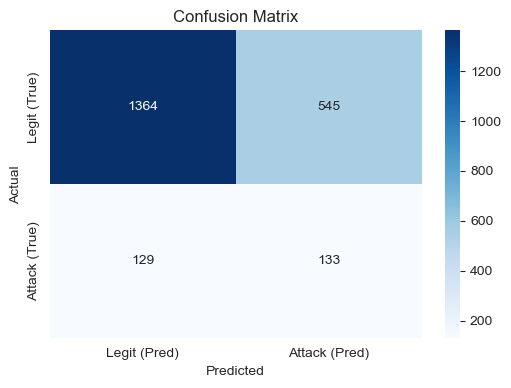

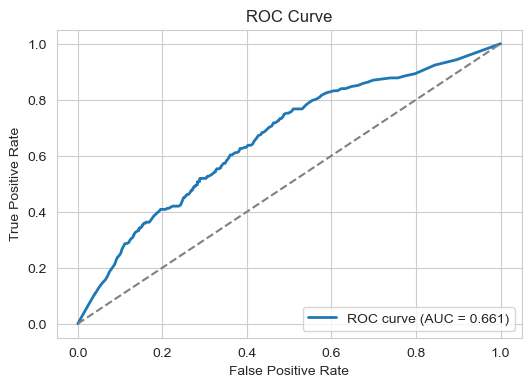

AUC = 0.661
✅ Model + scaler saved to bantai_model.pkl


In [8]:
# start training

bantai = BantAI_TravelAware(cache_file="geocache.json", ml_model_path="bantai_model.pkl", geocode_delay=1.0)

# Train with 20,000 rows and "Is Attack IP" as label
bantai.train_model_from_csv(
    r"C:\Users\Brando\Desktop\School\Project\BantAI_Datawave\rba-dataset.csv",
    nrows=20000,
    label_column="Is Attack IP",   # or "Is Account Takeover"
    use_smote=True,
    save_model=True
)

In [ ]:
# ------------------------
# USAGE EXAMPLE (bottom of file)
# ------------------------
if __name__ == "__main__":
    # change these paths
    dataset_path = r"C:\Users\Brando\Desktop\School\Project\BantAI_Datawave\rba-dataset.csv"
    model_path = "bantai_model.pkl"

    bantai = BantAI_TravelAware(cache_file="geocache.json", ml_model_path=model_path, geocode_delay=1.0)

    # Train ML component on a subset (e.g., nrows=20000 for initial run)
    # label_column can be "Is Attack IP" or "Is Account Takeover"
    bantai.train_model_from_csv(dataset_path, nrows=20000, label_column="Is Attack IP", use_smote=True, save_model=True)

    # Example: compute a unified risk for a sample user pair
    # You must provide last_login and current_login dicts with at least: time, City, Country, Device Type, User Agent String, Round-Trip Time [ms], Is Attack IP, Login Successful, ASN
    last_login = {
        "time": "2024-01-10 08:00:00",
        "City": "Manila",
        "Country": "PH",
        "Device Type": "mobile",
        "User Agent String": "Mozilla/5.0 ...",
        "Round-Trip Time [ms]": 50,
        "Is Attack IP": False,
        "Login Successful": True,
        "ASN": 398986,
        "user_id": "juan_dela_cruz_123"
    }
    current_login = {
        "time": "2024-01-20 19:30:00",
        "City": "Dubai",
        "Country": "AE",
        "Device Type": "mobile",
        "User Agent String": "Mozilla/5.0 ...",
        "Round-Trip Time [ms]": 120,
        "Is Attack IP": False,
        "Login Successful": True,
        "ASN": 9001,
        "user_id": "juan_dela_cruz_123"
    }

    # build a very small user history for behavioral scoring
    # ideally you would query your dataset for past rows for this user
    user_history_df = pd.DataFrame([last_login])

    result = bantai.unified_risk_score(user_history_df, last_login, current_login)
    print("\nUnified risk result:")
    print(result)